In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt

from typing import List
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split

# Configure plot defaults
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["grid.color"] = "#666666"

np.random.seed(0)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


# MF-SRegressor for the classical MF problem: Non-linear function

In [2]:
# original code
#  https://github.com/EmuKit/emukit/blob/main/emukit/test_functions/non_linear_sin.py


def nonlinear_sin_low(x, sd=0):
    """
    Low fidelity version of nonlinear sin function
    """

    return np.sin(8 * np.pi * x) + np.random.randn(x.shape[0], 1) * sd


def nonlinear_sin_high(x, sd=0):
    """
    High fidelity version of nonlinear sin function
    """

    return (x - np.sqrt(2)) * nonlinear_sin_low(x, 0) ** 2 + np.random.randn(
        x.shape[0], 1
    ) * sd

In [3]:
high_fidelity = nonlinear_sin_high
low_fidelity = nonlinear_sin_low

x_plot = np.linspace(0, 1, 200)[:, None]
y_plot_l = low_fidelity(x_plot)
y_plot_h = high_fidelity(x_plot)

n_low_fidelity_points = 50
n_high_fidelity_points = 15

x_train_l = np.linspace(0, 1, n_low_fidelity_points)[:, None]
y_train_l = low_fidelity(x_train_l)

x_train_h = x_train_l[::4, :]
y_train_h = high_fidelity(x_train_h)

In [4]:
y_train_h.shape, y_train_l.shape

((13, 1), (50, 1))

Text(0.5, 1.0, 'High and low fidelity functions')

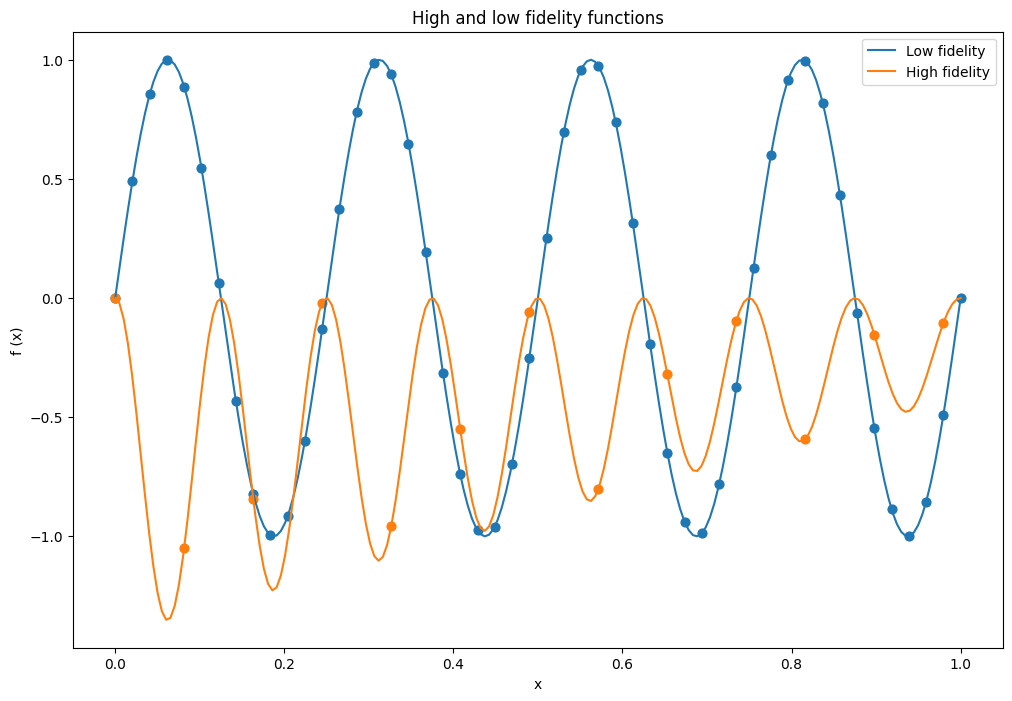

In [5]:
## Plot the original functions

plt.figure(figsize=(12, 8))
plt.plot(x_plot, y_plot_l, "C0")
plt.plot(x_plot, y_plot_h, "C1")
plt.scatter(x_train_l, y_train_l, color="C0", s=40)
plt.scatter(x_train_h, y_train_h, color="C1", s=40)
plt.ylabel("f (x)")
plt.xlabel("x")
plt.legend(["Low fidelity", "High fidelity"])
plt.title("High and low fidelity functions")

## MF-SR

In [6]:
class MultiFidelitySRegressor:
    """
    Multi-fidelity surrogate model that predicts the high-fidelity function.

    Parameters
    ----------
    model : PySRRegressor
        Low-fidelity model.
    model_mf : PySRRegressor
        Multi-fidelity model.
    complexity : int
        Complexity of the multi-fidelity model.
    """
    def __init__(self, model, model_mf, complexity=1):
        self.model = model
        self.model_mf = model_mf
        self.complexity = complexity

    def fit(self, x_l, y_l, x_h, y_h):
        """
        Fit the multi-fidelity model.

        Parameters
        ----------
        x_l : array-like
            Low-fidelity input data.
        y_l : array-like
            Low-fidelity target data.
        x_h : array-like
            High-fidelity input data.
        y_h : array-like
            High-fidelity target data.
        """
        # train LF model
        self.model.fit(x_l, y_l)
        # Predict LF model on HF input data
        f_l = self.model.predict(x_h)

        # Stack the LF model predictions with the HF input data
        _x_h = np.hstack([x_h, f_l[:, None]])

        self.model_mf.fit(_x_h, y_h)

    def predict(self, x):
        """
        Predict the high-fidelity function.
        """
        f_l = self.model.predict(x)
        _x = np.hstack([x, f_l[:, None]])
        return self.model_mf.predict(_x, self.complexity)

    def sympy(self):
        return self.model.sympy(), self.model_mf.sympy(self.complexity)

    def __call__(self, x):
        return self.predict(x)

    def __repr__(self):
        return f"MultiFidelitySRegressor(model={self.model}, model_mf={self.model_mf}, complexity={self.complexity})"

/Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The opti

Compiling Julia backend...


[ Info: Started!
/Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceW

Text(0.5, 1.0, 'High fidelity function')

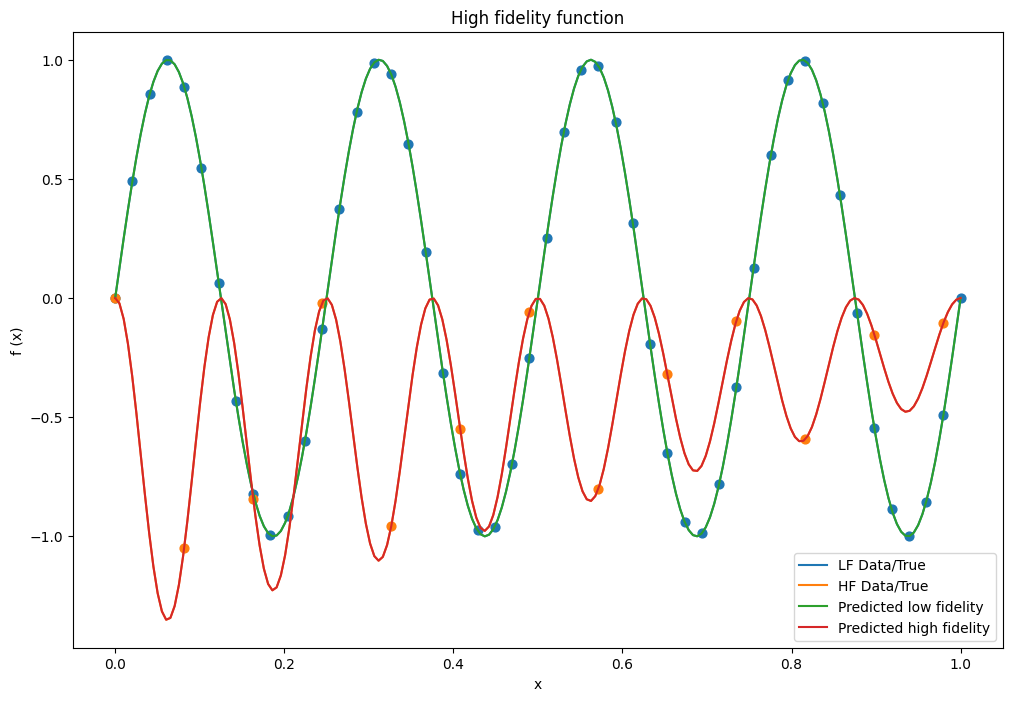

In [7]:
# Example usage
default_pysr_params = dict(
    populations=30,
    model_selection="best",
    denoise=True,
)

model = PySRRegressor(
    niterations=30,
    binary_operators=["+", "*", "-"],
    unary_operators=["cos", "exp", "sin", "square", "log"],
    **default_pysr_params,
)

model_mf = PySRRegressor(
    niterations=30,
    binary_operators=["+", "*", "-"],
    unary_operators=["cos", "exp", "sin", "square", "log"],
    **default_pysr_params,
)

# Fit the multi-fidelity model
model_mf_s = MultiFidelitySRegressor(model, model_mf, complexity=None)

model_mf_s.fit(x_train_l, y_train_l, x_train_h, y_train_h)

# Predict the high-fidelity function
y_predict_mf = model_mf_s(x_plot)
# predict the low-fidelity function
y_predict_l = model_mf_s.model.predict(x_plot)

plt.figure(figsize=(12, 8))
plt.plot(x_plot, y_plot_l, "C0")
plt.plot(x_plot, y_plot_h, "C1")
plt.plot(x_plot, y_predict_l, "C2")
plt.plot(x_plot, y_predict_mf, "C3")
plt.scatter(x_train_l, y_train_l, color="C0", s=40)
plt.scatter(x_train_h, y_train_h, color="C1", s=40)
plt.ylabel("f (x)")
plt.xlabel("x")
plt.legend(["LF Data/True", "HF Data/True", "Predicted low fidelity", "Predicted high fidelity"])
plt.title("High fidelity function")


In [8]:
model_mf_s.sympy()[0]

sin(x0*25.1324791576908)

In [9]:
model_mf_s.sympy()[1]

x1**2*(x0 - 1*0.41420457) - x1**2